# Named Entity Recognition

### Imports

In [1]:
import pandas as pd
import numpy as np
import spacy
import os
import networkx as nx
import matplotlib.pyplot as plt
import time 

from pyvis.network import Network
from spacy import displacy
from selenium import webdriver 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

### WebScraper

In [2]:
# Create driver 
driver = webdriver.Chrome(ChromeDriverManager().install())

# Go to GOT Character Wiki
page_url = "https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters"
driver.get(page_url)

# Find and assemble list of main and side characters 
main_characters = driver.find_elements(By.CLASS_NAME, 'mw-headline')[5:47]
side_characters = driver.find_elements(By.CLASS_NAME, 'mw-redirect')[107:193]
characters = main_characters + side_characters

# Convert selenium output to strings then transform list into DF
char_list = []
for elm in characters:
    char_list.append(elm.text)

# Create and modify character first-names and full names in DF 
char_df = pd.DataFrame(char_list,columns=['characters'])
char_df['character_firstname'] = char_df['characters'].apply(lambda x: x.split(' ', 1)[0])
char_df.character_firstname[0] = 'Ned'
char_df.character_firstname[19] = 'Sam'
char_df.character_firstname[6] = 'Mormont'
char_df.character_firstname[13] = 'Bran'
char_df.characters[19] = 'Sam Tarly'

[WDM] - Downloading: 100%|█████████████████| 8.84M/8.84M [00:00<00:00, 11.3MB/s]
/var/folders/d0/pj6481hn1lq9xd9r7rxx99xc0000gn/T/ipykernel_11754/228828282.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


### Load Book

In [3]:
# Get book1 files in data directory
all_books = [b for b in os.scandir('data')]

start = time.time()

NER = spacy.load('en_core_web_sm')
NER.max_length = 2800382
book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

end = time.time()
print("The time of execution of above program is :", (end-start))

The time of execution of above program is : 53.84602499008179


In [4]:
start = time.time()
# Parse book by sentence and store each respective named entity in corresponding dictionary 'key: values'
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

end = time.time()
print("The time of execution of above program is :", (end-start))

The time of execution of above program is : 734.9835169315338


In [5]:
# Filter out non-character entities
def filter_entity(ent_list, char_df):
    return [ent for ent in ent_list
            if ent in list(char_df.characters)
            or ent in list(char_df.character_firstname)]

In [6]:
# Create and filter entities column 
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, char_df))

# Filter out sentences without character entities 
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

# Create and transform entities column to first name basis 
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                              for item in x])

/var/folders/d0/pj6481hn1lq9xd9r7rxx99xc0000gn/T/ipykernel_11754/3341153716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


### Find Relationships

In [7]:
# Window size and relationship dictionary instantiation 
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

    # Remove diplicate characters next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i == 0) or char_list[i] != char_list[i-1]] 
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [8]:
# Transform newly created relationship dictionary into pd DF 
relationship_df = pd.DataFrame(relationships)
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

# Find relationship weight of each character 
relationship_df["value"] = 1 
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df = relationship_df.iloc[:233, :]

### Graph analysis and visualization

In [9]:
# Create a graph from a pandas dataframe 
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())

#### Graph visualization - Pyvis

In [10]:
net = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show("GOT.html")

GOT.html


### Most important characters in Game of Thrones

<Axes: >

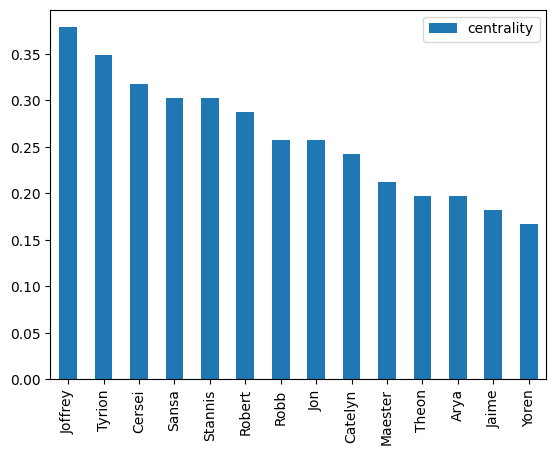

In [11]:
# Degree of centrality 
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

# Plot top 15 nodes
degree_df.sort_values('centrality', ascending=False)[0:14].plot(kind="bar")

<Axes: >

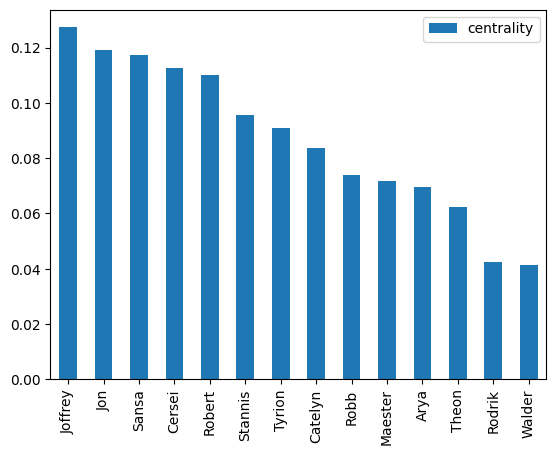

In [12]:
# Betweenness centrality 
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])

# Plot top 15 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:14].plot(kind="bar")

<Axes: >

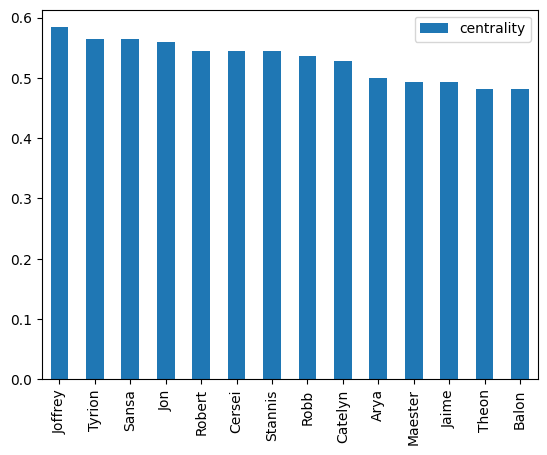

In [13]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

# Plot top 15 nodes 
closeness_df.sort_values('centrality', ascending=False)[0:14].plot(kind="bar")

### Community detection

In [16]:
import community as community_louvain

communities = community_louvain.best_partition(G)

# Save centrality measures 
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'degree_betweenness')
nx.set_node_attributes(G, closeness_dict, 'degree_closeness')
nx.set_node_attributes(G, communities, 'group')

#### Graph visualization - Pyvis

In [17]:
com_net = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.from_nx(G)
com_net.show("GOT_com.html")

GOT_com.html


## Functions 

In [18]:
def ner(file_name):
    """
    Function to process text from a text file (.txt) using Spacy.
    
    Params:
    file_name -- name of txt file as string 
    
    Returns:
    a processed doc file using Spacy English language model 
    
    """
    # Load spacy English language model
    NER = spacy.load('en_core_web_sm')
    NER.max_length = 2400382
    book_text = open(book).read()
    book_doc = NER(book_text)
    return book_doc



def get_ne_list_per_sentence(spacy_doc):
    """
    Get a list of entites per sentence of a Spacy document and store in a dataframe.
    
    Params:
    spacy_doc -- a Spacy processed document
    
    Returns:
    a dataframe containing the sentences and corresponding list of recognised named entities in the sentences
    """
    
    # Parse book by sentence and store each respective named entity in corresponding dictionary 'key: values'
    sent_entity_df = []

    for sent in book_doc.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})

    sent_entity_df = pd.DataFrame(sent_entity_df)

    return sent_entity_df


def filter_entity(ent_list, char_df):
    """
    Function to filter out non-character entities.
    
    Params:
    ent_list -- list of entities to be filtered
    character_df -- a dataframe contain characters' names and characters' first names
    
    Returns:
    a list of entities that are characters (matching by names or first names).
    
    """
    return [ent for ent in ent_list
            if ent in list(char_df.characters)
            or ent in list(char_df.character_firstname)]


def create_relationships(df, window_size):
    
    """
    Create a dataframe of relationships based on the df dataframe (containing lists of chracters per sentence) and the  window size of n sentences.
    
    Params:
    df -- a dataframe containing a column called character_entities with the list of chracters for each sentence of a document.
    window_size -- size of the windows (number of sentences) for creating relationships between two adjacent characters in the text.
    
    Returns:
    a relationship dataframe containing 3 columns: source, target, value.
    
    """
    
    # Window size and relationship dictionary instantiation 
    relationships = []

    for i in range(sent_entity_df_filtered.index[-1]):
        end_i = min(i+5, sent_entity_df_filtered.index[-1])
        char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

        # Remove diplicate characters next to each other
        char_unique = [char_list[i] for i in range(len(char_list))
                      if (i == 0) or char_list[i] != char_list[i-1]] 
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
           
    # Transform newly created relationship dictionary into pd DF 
    relationship_df = pd.DataFrame(relationships)
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

    # Find relationship weight of each character and select the first 250 heavily weighted relationships 
    relationship_df["value"] = 1 
    relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
    relationship_df = relationship_df.iloc[:233, :]
                
    return relationship_df


def centrality_dev(G):
    
    # Degree of centrality
    degree_dict = nx.degree_centrality(G)
    degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['degree centrality'])

    # Betweenness centrality 
    betweenness_dict = nx.betweenness_centrality(G)
    betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['betweenness centrality'])
    
    # Closeness centrality
    closeness_dict = nx.closeness_centrality(G)
    closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['closeness centrality'])
        
    return [degree_dict, betweenness_dict, closeness_dict]

## Evolution of characters' importance

In [19]:
start = time.time()

# Inititate empty list for graphs from books 
books_graph = []

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

# Loop through book list and create graphs
for book in all_books:
    book_text = open(book).read()
    book_doc = NER(book_text)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_doc)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, char_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G)
    
end = time.time()
print("The time of execution of above program is :", (end-start))

/var/folders/d0/pj6481hn1lq9xd9r7rxx99xc0000gn/T/ipykernel_11754/58591422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/var/folders/d0/pj6481hn1lq9xd9r7rxx99xc0000gn/T/ipykernel_11754/58591422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/var

The time of execution of above program is : 5243.474498987198


#### Top 5 central Characters importance measured over the course of the GOT books series

<Axes: >

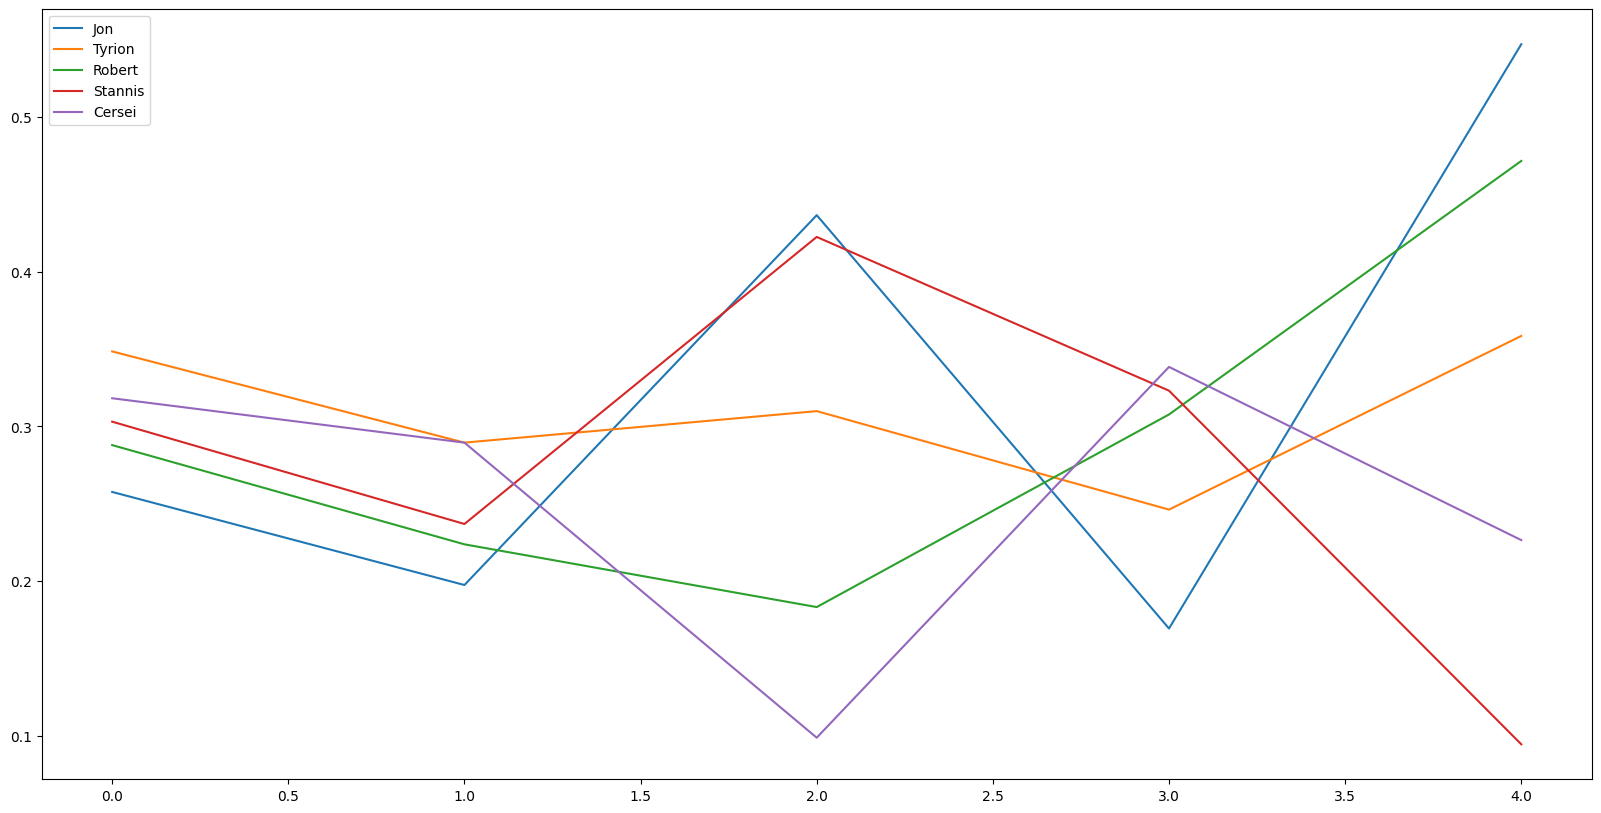

In [20]:
# Create a list of degree centrality of all the books 
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DF from the list of degree centraliities in all the books 
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of the top 5 central characters
degree_evol_df[degree_evol_df.sum().sort_values(ascending=False)[:5].index.values].plot(figsize=(20, 10))

## Data visiualtions over-time - Pyvis

#### Book1

In [21]:
G1 = books_graph[0]
x1 = centrality_dev(G1)
communities1 = community_louvain.best_partition(G1)


# Save centrality measures 
nx.set_node_attributes(G1, x1[0], 'degree_centrality')
nx.set_node_attributes(G1, x1[1], 'degree_betweenness')
nx.set_node_attributes(G1, x1[2], 'degree_closeness')
nx.set_node_attributes(G1, communities1, 'group')

com_net1 = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net1.from_nx(G1)
com_net1.from_nx(G1)

com_net1.show("GOT_comB1.html")

GOT_comB1.html


#### Book2

In [22]:
G2 = books_graph[1]
x2 = centrality_dev(G2)
communities2 = community_louvain.best_partition(G2)


# Save centrality measures 
nx.set_node_attributes(G2, x2[0], 'degree_centrality')
nx.set_node_attributes(G2, x2[1], 'degree_betweenness')
nx.set_node_attributes(G2, x2[2], 'degree_closeness')
nx.set_node_attributes(G2, communities2, 'group')

com_net2 = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net2.from_nx(G1)
com_net2.from_nx(G1)
com_net2.show("GOT_comB2.html")

GOT_comB2.html


#### Book3

In [23]:
G3 = books_graph[2]
x3 = centrality_dev(G3)
communities3 = community_louvain.best_partition(G3)


# Save centrality measures 
nx.set_node_attributes(G3, x1[0], 'degree_centrality')
nx.set_node_attributes(G3, x1[1], 'degree_betweenness')
nx.set_node_attributes(G3, x1[2], 'degree_closeness')
nx.set_node_attributes(G3, communities3, 'group')

com_net3 = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net3.from_nx(G3)
com_net3.from_nx(G3)
com_net3.show("GOT_comB3.html")

GOT_comB3.html


#### Book4

In [24]:
G4 = books_graph[3]
x4 = centrality_dev(G4)
communities4 = community_louvain.best_partition(G4)


# Save centrality measures 
nx.set_node_attributes(G4, x4[0], 'degree_centrality')
nx.set_node_attributes(G4, x4[1], 'degree_betweenness')
nx.set_node_attributes(G4, x4[2], 'degree_closeness')
nx.set_node_attributes(G4, communities4, 'group')

com_net4 = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net4.from_nx(G4)
com_net4.from_nx(G4)
com_net4.show("GOT_comB4.html")

GOT_comB4.html


#### Book5

In [25]:
G5 = books_graph[4]
x5 = centrality_dev(G5)
communities5 = community_louvain.best_partition(G5)


# Save centrality measures 
nx.set_node_attributes(G5, x5[0], 'degree_centrality')
nx.set_node_attributes(G5, x5[1], 'degree_betweenness')
nx.set_node_attributes(G5, x5[2], 'degree_closeness')
nx.set_node_attributes(G5, communities5, 'group')

com_net5 = Network(notebook = True, width="1200px", height="900px", bgcolor='#222222', font_color='white')
com_net5.from_nx(G5)
com_net5.from_nx(G5)
com_net5.show("GOT_comB5.html")

GOT_comB5.html


#### Branndon-M